## Introduction
This notebook is intended to be utilised for identifying transitive privileges. Transitive privileges are most often the reason for several breaches and they don't come out often in straight forward security assessments. Tools such as Azure Hound are available to achieve the same but collecting the data and uploading an agent sometimes doesn't work for compliance reasons or more often we found that it's not very flexible like a simple notebook. Plus the advantage of a notebook is that, this could be integrated in workflow to automatically notify/remediate which isn't possible in the free version of these tools.

## Author
The notebook was created by Pallavi Kumar Jha (Microsoft Limited) and Subhash Popuri (Microsoft Limited). 

## Credits
Several open source libraries are leveraged as a part of the notebook. I'd like to thank all the authors of these packages for making our lives easier.

## Access this notebook
The notebook is uploaded to GitHub, to support the security community. Please feel free to clone/fork and contribute back. The notebook is accessed here: [Github Link.]()

## Required libraries
The following libraries are required for the notebook to run.
1. requests - For sending requests to Azure API.
2. re - For occassional parsing
3. ploty - For plotting graphs
4. networkx - For plotting graphs
5. matplotlib - For plotting graphs

### 1. Install required libraries

In [0]:
# !pip install requests, re, plotly, networkx, matplolib

#### 2. Defining functions that are required to get token (via device code flow) & fetch data from Azure API

In [0]:
import requests, re
def getToken(res):
    url = "https://login.microsoftonline.com/6d9c9e36-aa5a-459e-9ef1-e0113764e452/oauth2/devicecode?api-version=1.0"
    payload = {'client_id': '1950a258-227b-4e31-a9cf-717495945fc2',
    'resource': res}
    files=[
    ]
    headers = {
    }
    response = requests.request("POST", url, headers=headers, data=payload, files=files)
    device_code = response.json()['device_code']
    input(response.json()['message'])
    url = "https://login.microsoftonline.com/6d9c9e36-aa5a-459e-9ef1-e0113764e452/oauth2/token?api-version=1.0"
    payload = {'code': device_code,
'grant_type': 'urn:ietf:params:oauth:grant-type:device_code',
'client_id': '1950a258-227b-4e31-a9cf-717495945fc2'}
    files=[
    ]
    headers = {
   }
    response = requests.request("POST", url, headers=headers, data=payload, files=files)
    return response.json()['access_token']

In [0]:
azure_token=getToken('https://management.azure.com')

To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code SBRHJQCTC to authenticate. 

In [0]:
graph_token=getToken('https://graph.microsoft.com')

To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code ISGUPDSTU to authenticate. 

In [0]:
def getRoleDefinitions(token):
    headers = {"Authorization":"Bearer "+token}
    roles = requests.get("https://management.azure.com/providers/Microsoft.Authorization/roleDefinitions?api-version=2022-05-01-preview",headers=headers).json()
    roledef = list([(x['id'], x['properties']['roleName']) for x in roles['value']])
    return roledef

def getAllUsers(token):
    counter = 0
    headers = {"Authorization":"Bearer "+token}
    users = requests.get("https://graph.microsoft.com/v1.0/users",headers=headers).json()
    userx = []
    # print(users)
    userx = userx + [(x['id'],x['userPrincipalName'],x['displayName']) for x in users['value']]
    while True:
        if counter == 200:
            break
        if '@odata.nextLink' in users.keys():
            res = requests.get(users['@odata.nextLink'],headers=headers).json()
            userx = userx + [(x['id'],x['userPrincipalName'],x['displayName']) for x in res['value']]
            users = res
        else:
            break
        counter = counter + 1
    return userx

def getKeyVaults(token, subs):
    headers = {"Authorization":"Bearer "+token}
    for sub in subs:
        url = "https://management.azure.com/subscriptions/"+sub+"/resources?$filter=resourceType eq 'Microsoft.KeyVault/vaults'&api-version=2015-11-01"
        kvs = requests.get(url,headers=headers).json()
    return kvs['value']

def getSubscriptions(token):
    headers = {"Authorization":"Bearer "+token}
    url = "https://management.azure.com/subscriptions?api-version=2022-12-01"
    subs = requests.get(url,headers=headers).json()
    #print(subs)
    subx = [x['id'].split("/")[-1] for x in subs['value']]
    return subx

def getKeyVaultPermissions(token,resource_id,user_id,roles):
    headers = {"Authorization":"Bearer "+token}
    perms = requests.get("https://management.azure.com"+resource_id+"/providers/Microsoft.Authorization/roleAssignments?$filter=atScope() and assignedTo('"+user_id+"')&api-version=2020-04-01-preview",headers=headers).json()
    perms = [(x['properties']['roleDefinitionId'],x['properties']['principalId']) for x in perms['value']]
    perms = [("/"+"/".join(x[0].split("/")[3:]),x[1]) for x in perms]
    # print(perm?s)
    z = []
    for i in perms:
        for j in roles:
            if j[0] == i[0]:
                z.append([j[1],i[0],i[1],j[0],resource_id])
    return z

def getManagedIdentities(token,subscriptions):
    kvs = []
    headers = {"Authorization":"Bearer "+token}
    for sub in subscriptions:
        url = "https://management.azure.com/subscriptions/"+sub+"/resources?$filter=resourceType eq 'Microsoft.ManagedIdentity/userAssignedIdentities'&api-version=2015-11-01"
        kvs = kvs + [requests.get(url,headers=headers).json()]
    for sub in subscriptions:
        url = "https://management.azure.com/subscriptions/"+sub+"/resources?$filter=resourceType eq 'Microsoft.ManagedIdentity/systemAssignedIdentities'&api-version=2015-11-01"
        kvs = kvs + [requests.get(url,headers=headers).json()]
    return kvs

def getAllRes(token,subs):
    headers = {"Authorization": "Bearer "+token}
    spsx = []
    for sub in subs:
        url = "https://management.azure.com/subscriptions/"+sub+"/resources?api-version=2021-04-01"
        sps = requests.get(url, headers=headers).json()
        spsx = spsx + [sps['value']]
    return spsx

def getRoleAssignmentsForUser(azure_token,users,subs):
    fulllist = []
    headers = {"Authorization":"Bearer "+azure_token}
    for user_id in users:
        for sub in subs:
            url = "https://management.azure.com/subscriptions/"+sub+"/providers/Microsoft.Authorization/roleAssignments?%24filter=assignedTo(%27"+user_id[0]+"%27)&api-version=2020-04-01-preview"
            response = requests.get(url,headers=headers)
            fulllist.append(response.json()['value'])
    return fulllist

def getRolesforMSI(azure_token,msis):
    fulllist = []
    headers = {"Authorization": "Bearer "+ azure_token}
    for msix in msis:
        try:
            url = "https://management.azure.com/subscriptions/"+msix['subscription']+"/providers/Microsoft.Authorization/roleAssignments?%24filter=assignedTo(%27"+msix['principalId']+"%27)&api-version=2020-04-01-preview"
            response = requests.get(url,headers=headers)
            # print()
            fulllist.append([msix['res'],response.json()['value'][0]['properties']['scope']])
        except:
            continue
    return fulllist


#### 3. Calling the functions (defined already) to get information related to Subscriptions, users, MSIs, 

In [0]:
subs = getSubscriptions(azure_token)

In [0]:
users = getAllUsers(graph_token)

In [0]:
msi = getManagedIdentities(azure_token,subs)

#### 4. Parsing the resources list to get list of resources with MSI's attached to them.

In [0]:
all_res = getAllRes(azure_token,subs)
msi = [x for x in all_res[0] if x['type'] == "Microsoft.ManagedIdentity/userAssignedIdentities"]
vms = [x for x in all_res[0] if x['type'] == "Microsoft.Compute/virtualMachines"]
logic_apps = [x for x in all_res[0] if x['type'] == "Microsoft.Logic/workflows"]
msi_list = []

for x in logic_apps:
    small_list = {}
    small_list['subscription'] = x['id'].split("/")[2]
    small_list['principalId'] = [x['principalId'] for x in x['identity']['userAssignedIdentities'].values()][0]
    small_list['res'] = x['id']
    msi_list.append(small_list)

for x in vms:
    small_list = {}
    small_list['subscription'] = x['id'].split("/")[2]
    small_list['principalId'] = x['identity']['principalId']
    small_list['res'] = x['id']
    msi_list.append(small_list)

#### 5. Getting Permissions and correlating them.

In [0]:
perms_list = []
for x in getRoleAssignmentsForUser(azure_token,users,subs):
    for i in x:
        perms_list.append([i['properties']['principalId'],i['properties']['scope']])
perms_list = perms_list + getRolesforMSI(azure_token, msi_list)

In [0]:
subxs = ["/subscriptions/"+x for x in subs]

#### 6. Plotting it and Visualing it nicely (hopefully :-))

In [0]:
import plotly.graph_objects as go

import networkx as nx

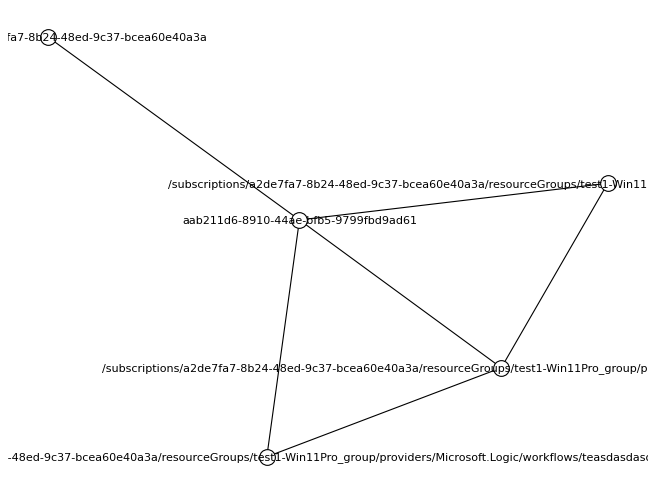

In [0]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

# Create a graph object
G = nx.Graph()
res = [x[0] for x in users] + [x['id'] for x in all_res[0]] + subxs

perm = []
for i in perms_list:
    perm = perm + [(i[0],i[1])]
final_nodes= []
for x in res:
    for i in perms_list:
        if x in i[0] or x in i[1]:
            if "/" in x:
                final_nodes.append(x.split("/")[-2])
            else:
                final_nodes.append(x)

# Add nodes to the graph
# for i in set(final_nodes):
#     G.add_node(i)
perm = []
for i in perms_list:
    perm = perm + [(i[0],i[1])]

for i in perm:
    G.add_edge(i[0],i[1],length=500)

options = {
    "font_size": 10,
    "node_size": 200,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
}
nx.draw(G,with_labels = True,**options)

# Display the graph
ax = plt.gca()
ax.margins(0.02)
plt.axis("off")
plt.show()
plt.show()
